In [446]:
import json
import os
import re
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

In [447]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

In [448]:
def load_json_data(file_path: str) -> pd.DataFrame:
    """Load data from JSON file."""
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*time.*|.*date*.', col,
                                        re.IGNORECASE)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process time columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.

    Returns:
    pd.DataFrame: The processed dataframe.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*|.*date*.', col, re.IGNORECASE)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two dataframes by time.

    Parameters:
    df1 (pd.DataFrame): The first dataframe.
    df2 (pd.DataFrame): The second dataframe.

    Returns:
    pd.DataFrame: The merged dataframe.
    """
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    """
    Filters a DataFrame based on a list of years.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to filter.
        years_to_analyze (List[int]): The list of years to keep.
        
    Returns:
        filtered_df (pd.DataFrame): The filtered DataFrame.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*|.*date*.', col, re.IGNORECASE)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    """
    Calculate the correlation between two columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.

    Returns:
    tuple: A tuple containing the Pearson, Kendall, and Spearman correlation coefficients.
    """
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    kendal_tau = df[col1].corr(df[col2], method='kendall')
    spearman = df[col1].corr(df[col2], method='spearman')
    return correlation, kendal_tau, spearman


def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    """
    Function to plot a scatter plot from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_col (str): Name of the column to be plotted on the y-axis.

    Returns:
    None
    """
    # Check if columns exist in dataframe
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("One or both columns do not exist in the dataframe")

    # Check if columns contain numerical data
    if not pd.api.types.is_numeric_dtype(
            df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("One or both columns are not numeric")

    plt.figure(figsize=(10, 8))
    plt.scatter(df[x_col], df[y_col])
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def plot_scatter_multiple(df: pd.DataFrame, x_col: str,
                          y_cols: List[str]) -> None:
    """
    Function to plot multiple scatter plots from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_cols (List[str]): List of column names to be plotted on the y-axis.

    Returns:
    None
    """
    if len(y_cols) == 1:
        plot_scatter(df, x_col, y_cols[0])
        return

    # Check if x column exists in dataframe
    if x_col not in df.columns:
        raise ValueError("X column does not exist in the dataframe")

    # Check if x column contains numerical data
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError("X column is not numeric")

    # Check if all y columns exist in dataframe and contain numerical data
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column {y_col} does not exist in the dataframe")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column {y_col} is not numeric")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(
        f'{plot_sat_name}: plot of {x_col} ({plot_desc_data_name}) vs multiple y-columns')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    """
    Calculate correlations between each pair of columns from two lists in a DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    col_list1 (List[str]): List of column names to correlate with col_list2.
    col_list2 (List[str]): List of column names to correlate with col_list1.
    """
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                correlation, kendal_tau, spearman = calculate_correlation(df,
                                                                          col1,
                                                                          col2)
                print(f"sampling=[{len(df[col1])}]")
                print(
                    f"Correlation [{col1}] vs [{col2}]: classic=[{correlation}], spearman=[{spearman}], kendal_tau=[{kendal_tau}]")
            else:
                col_list2.remove(col1)
        plot_scatter_multiple(df, col1, col_list2)


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes columns from a DataFrame that are not of type float or int.
    The first column is ignored.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with non-numeric columns removed.
    """
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def is_column_constant(df: pd.DataFrame, column: str,
                       required_unique_values_amount: int = 1) -> bool:
    """Check if all non-NaN values in a DataFrame column are the same."""
    unique_values = df[column].dropna().unique()
    return len(unique_values) <= required_unique_values_amount


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                           2014]) -> None:
    # Preprocess solar data
    df_solar = preprocess_solar_data(solar_data_file)

    # Preprocess satellite data
    df_satellite = preprocess_satellite_data(satellite_data_file,
                                             years_to_analyze)

    # Extract column names excluding time/date columns
    solar_column_names = [col for col in df_solar.columns if
                          not re.match(r'.*time.*|.*date*.', col,
                                       re.IGNORECASE)]
    satellite_column_names = [col for col in df_satellite.columns if
                              not re.match(r'.*time.*|.*date*.', col,
                                           re.IGNORECASE)]

    # Constants for the uniqueness coefficient threshold and the solar column index
    uniqueness_coefficient_threshold: float = 0.01
    solar_column_index: int = 0

    for satellite_column in satellite_column_names:
        min_unique_count = int(uniqueness_coefficient_threshold * len(
            df_solar[solar_column_names[solar_column_index]]))

        if is_column_constant(df_satellite, satellite_column, min_unique_count):
            print(
                f"Skipping column=[{satellite_column}]: not enough unique values.")
            return

    # Merge dataframes by time
    df_solar_satellite_merged = merge_dataframes_by_time(df_solar, df_satellite)

    # Calculate correlations and plot
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)


In [449]:
import glob


def analyze_satellite(sat_name: str):
    observed_solar_cycle_data_path = '../data/swpc_observed_ssn.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    global plot_sat_name
    plot_sat_name = sat_name

    for sat_file in sat_csv_data_files:
        global plot_desc_data_name
        plot_desc_data_name = os.path.basename(sat_file)
        plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '', plot_desc_data_name,
                                     flags=re.IGNORECASE)

        process(solar_data_file=observed_solar_cycle_data_path,
                satellite_data_file=os.path.abspath(sat_file))

Skipping column=[Battery]: not enough unique values.
Skipping column=[3.3V]: not enough unique values.
Skipping column=[5V]: not enough unique values.
sampling=[1431]
Correlation [Battery Bus] vs [swpc_ssn]: classic=[0.13672412903702072], spearman=[0.39612621911017304], kendal_tau=[0.27477822293117526]


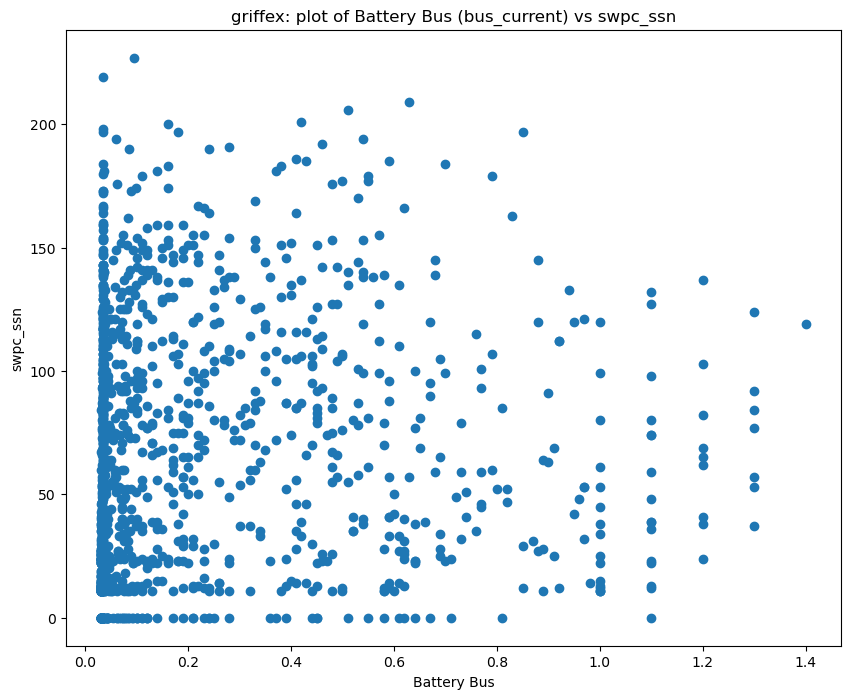

Skipping column=[Battery Bus]: not enough unique values.
sampling=[1431]
Correlation [40379.median] vs [swpc_ssn]: classic=[0.46315355052211304], spearman=[0.4759659161682569], kendal_tau=[0.32450245018819246]


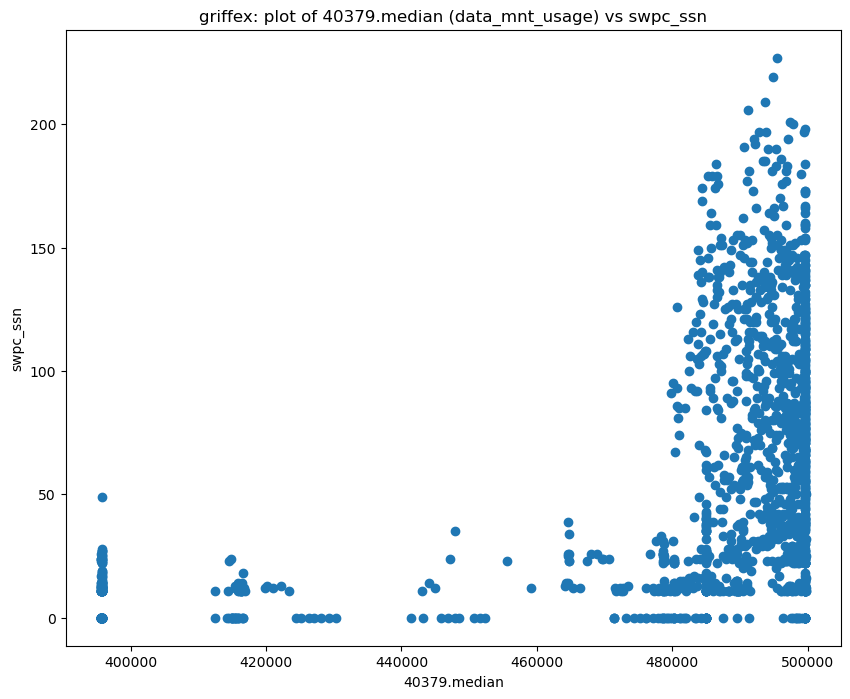

sampling=[1422]
Correlation [40379.freemem] vs [swpc_ssn]: classic=[-0.2553320454993292], spearman=[-0.28660957028269796], kendal_tau=[-0.19699078323395622]


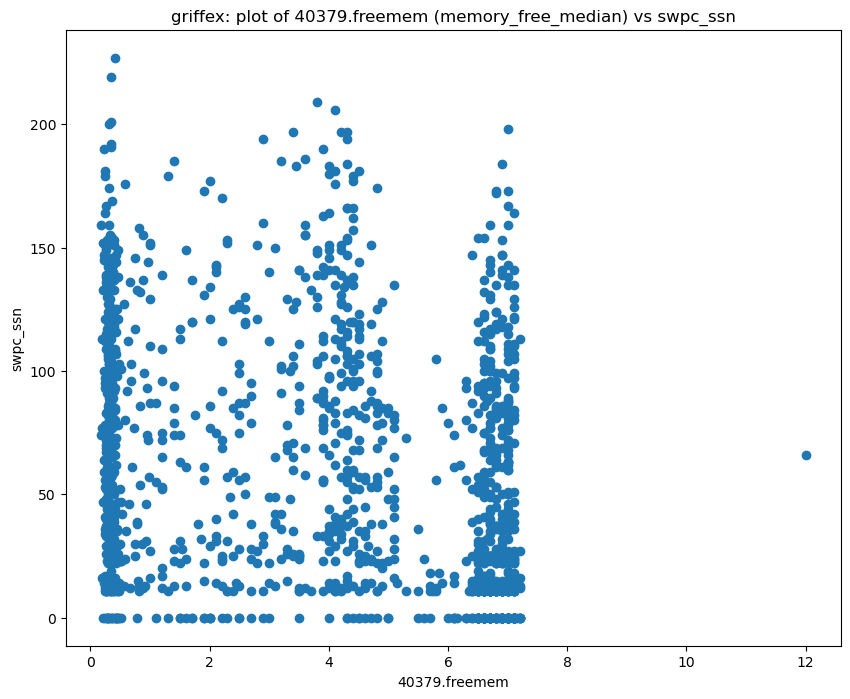

Skipping column=[40379.median]: not enough unique values.
sampling=[1431]
Correlation [resets] vs [swpc_ssn]: classic=[0.17805007116349097], spearman=[0.3894670351522071], kendal_tau=[0.28077806323937066]


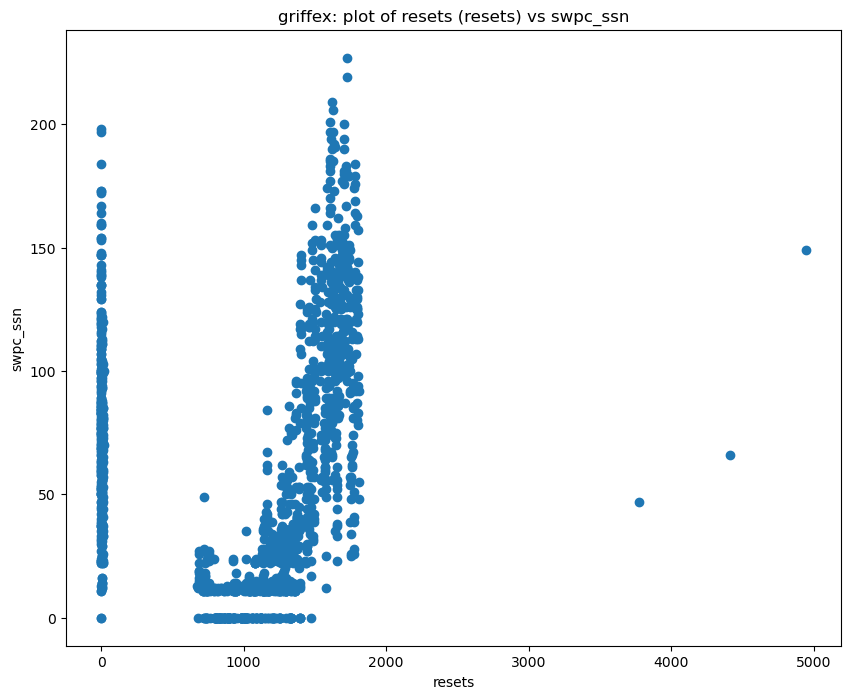

Skipping column=[40379.min]: not enough unique values.


In [450]:
analyze_satellite('griffex')

In [451]:
analyze_satellite('cas-5a')

Skipping column=[VHF AGC]: not enough unique values.
Skipping column=[54684.mode_mode]: not enough unique values.
Skipping column=[UHF1 Power]: not enough unique values.
Skipping column=[IHU]: not enough unique values.
Skipping column=[IHU]: not enough unique values.
Skipping column=[Total Solar Array Current]: not enough unique values.


sampling=[626]
Correlation [reseat] vs [swpc_ssn]: classic=[0.5918942117251357], spearman=[0.49899381760266887], kendal_tau=[0.3784094723883098]


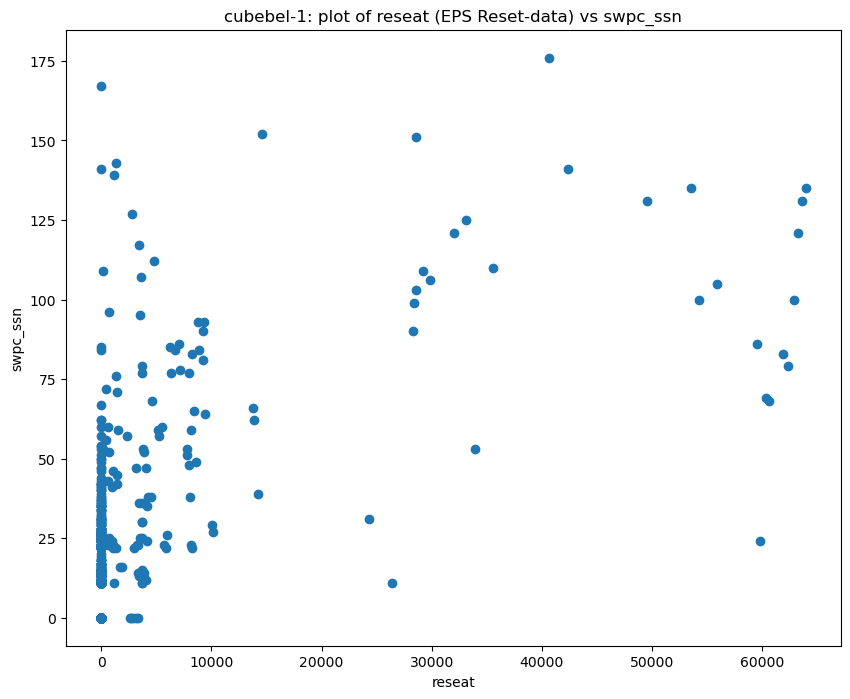

sampling=[1449]
Correlation [Framecount] vs [swpc_ssn]: classic=[0.554271199314867], spearman=[0.8313510615110348], kendal_tau=[0.6285633444485683]


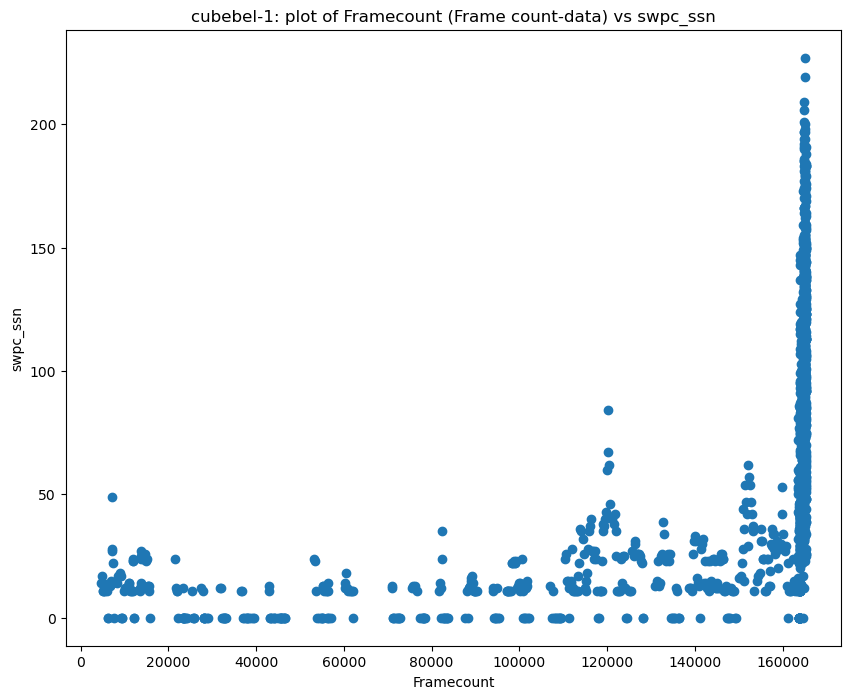

Skipping column=[1 East passes only]: not enough unique values.
Skipping column=[43666.ctl]: not enough unique values.
sampling=[626]
Correlation [Panel X Current] vs [swpc_ssn]: classic=[0.12318551568737511], spearman=[-0.021670033308069006], kendal_tau=[-0.011468451313746915]


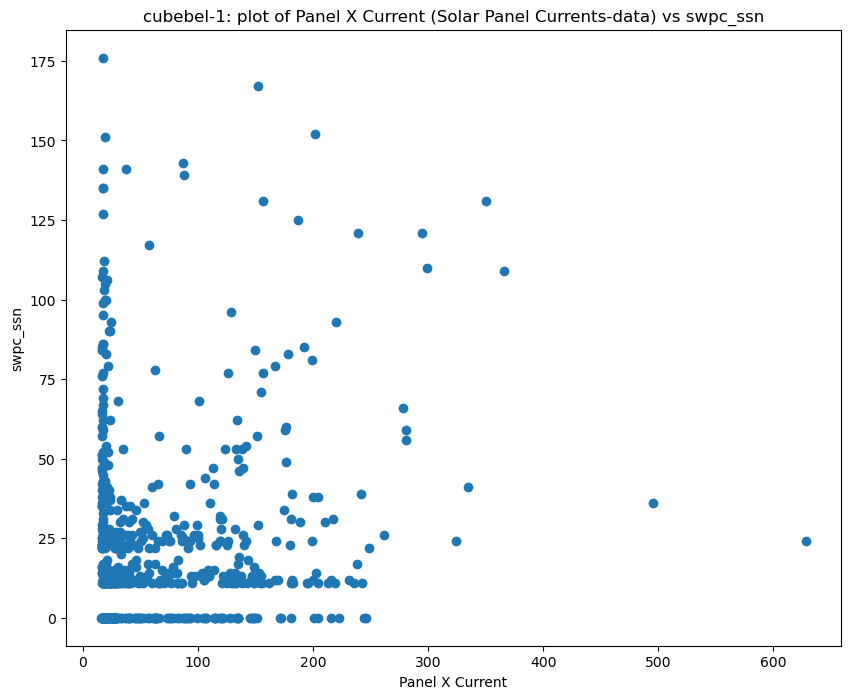

Skipping column=[43666.distinct]: not enough unique values.
Skipping column=[43666.distinct]: not enough unique values.
Skipping column=[43666.distinct]: not enough unique values.
Skipping column=[43666.distinct]: not enough unique values.
Skipping column=[43666.distinct]: not enough unique values.


In [452]:
analyze_satellite('cubebel-1')

sampling=[225]
Correlation [beacon_reset_total_cnt] vs [swpc_ssn]: classic=[0.06308189739717418], spearman=[0.047925029426530846], kendal_tau=[0.031805614469253944]


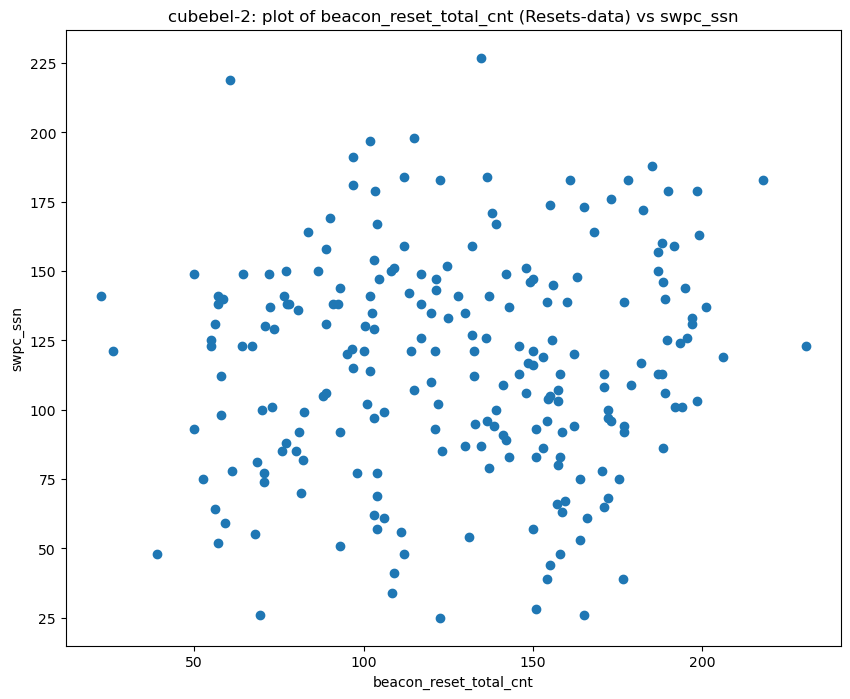

sampling=[224]
Correlation [tlm_mb_solarpanel_1_current()] vs [swpc_ssn]: classic=[0.20165144177141822], spearman=[0.07949192959089238], kendal_tau=[0.05998507970674087]


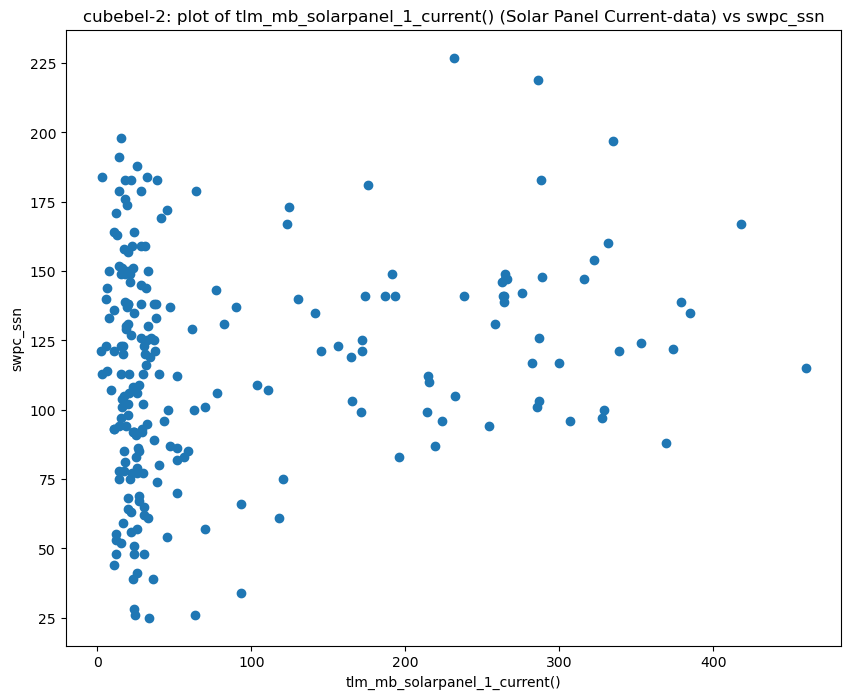

sampling=[224]
Correlation [tlm_mb_solartemp_0_temp_0] vs [swpc_ssn]: classic=[0.034366425753403936], spearman=[-0.06787932799379075], kendal_tau=[-0.04279696273158506]


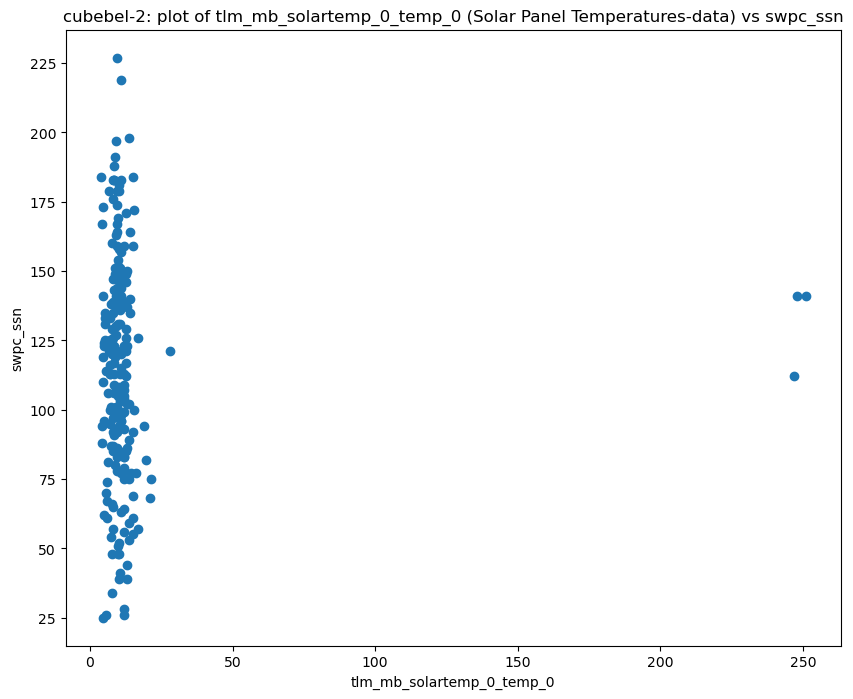

Skipping column=[tlm_mb_solarpanel_0_volt_pos]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[tlm_trx_cmn_mcu_temp]: not enough unique values.
Skipping column=[tlm_mb_ant_1_v]: not enough unique values.
sampling=[224]
Correlation [tlm_mb_adc_temp_1] vs [swpc_ssn]: classic=[0.014141174608712236], spearman=[-0.10702702974543703], kendal_tau=[-0.07207605643073958]


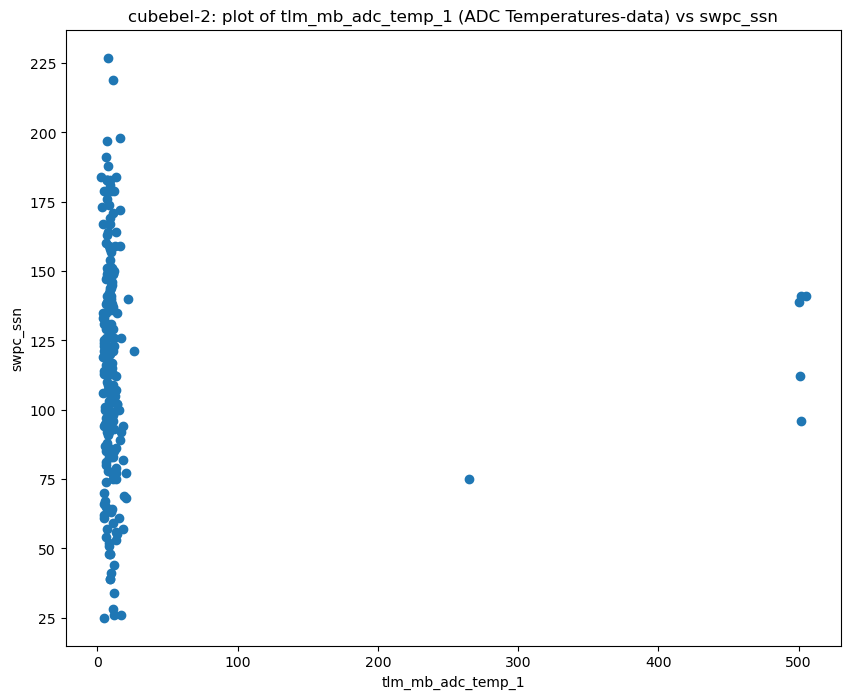

Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[tlm_mb_bttpck_0_element_0_current]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[57175.distinct]: not enough unique values.
Skipping column=[beacon_rx_settings]: not enough unique values.
sampling=[1449]
Correlation [9V1KG] vs [swpc_ssn]: classic=[0.314838698950454], spearman=[0.4074446470220524], kendal_tau=[0.32326963017393173]


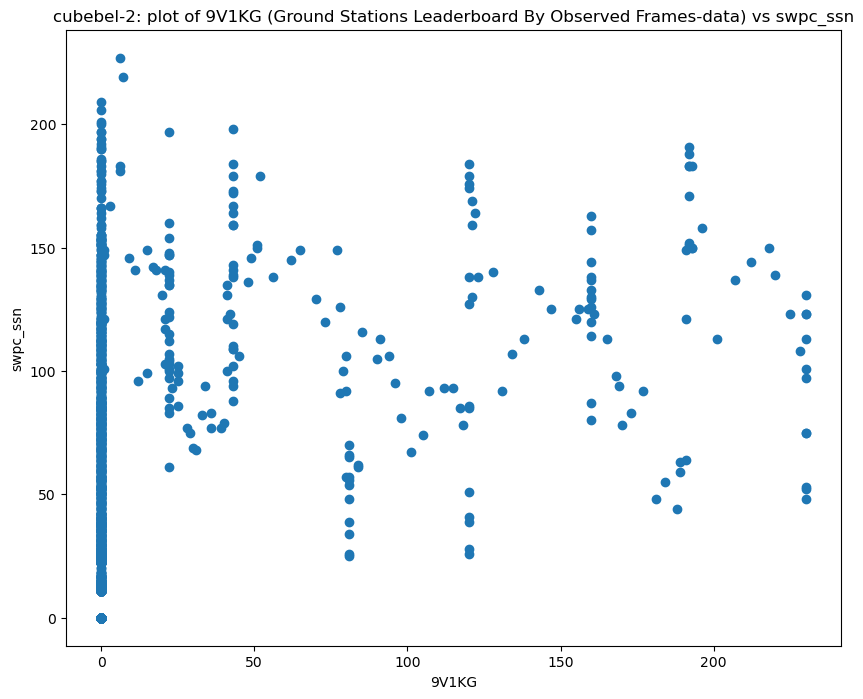

Skipping column=[57175.ctl]: not enough unique values.
sampling=[224]
Correlation [57175.tlm_mb] vs [swpc_ssn]: classic=[-0.03920938837919507], spearman=[-0.0218143563391009], kendal_tau=[-0.016273330110514843]


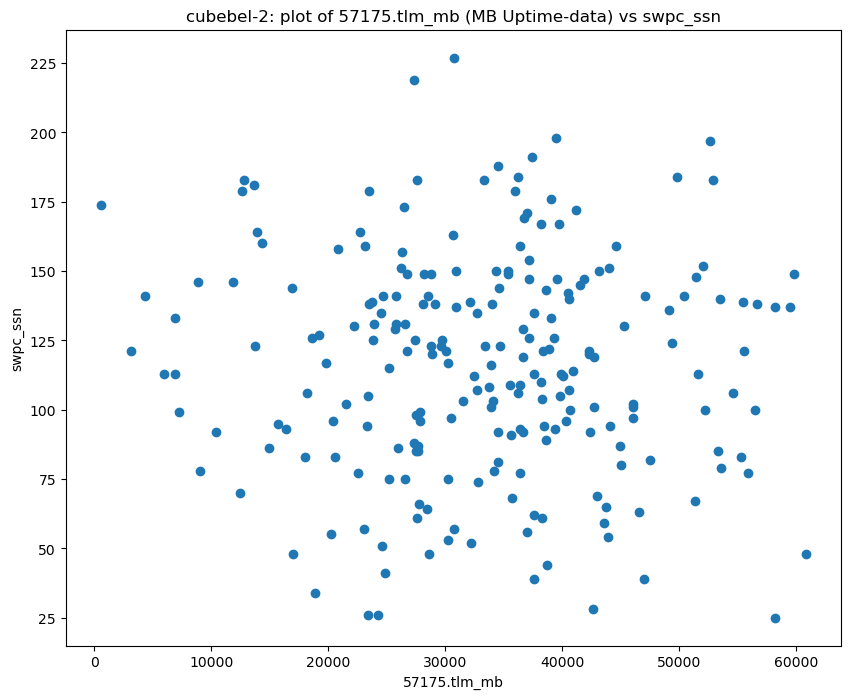

In [453]:
analyze_satellite('cubebel-2')

In [454]:
analyze_satellite('delfi-pq')

Skipping column=[51074.mode]: not enough unique values.
Skipping column=[Current]: not enough unique values.
Skipping column=[Cell Xm]: not enough unique values.
Skipping column=[Temp]: not enough unique values.


In [455]:
analyze_satellite('dhabisat')

Skipping column=[Latitude]: not enough unique values.
Skipping column=[OBC Reset Counter]: not enough unique values.
Skipping column=[X Position]: not enough unique values.
Skipping column=[OBC Reset Count]: not enough unique values.
Skipping column=[X Velocity]: not enough unique values.
Skipping column=[X Wheel Speed]: not enough unique values.
Skipping column=[Altitute]: not enough unique values.
Skipping column=[X Angular Rate]: not enough unique values.
Skipping column=[ECEF Position X]: not enough unique values.
Skipping column=[EPS Last Error]: not enough unique values.
Skipping column=[Estimated X Angular Rate]: not enough unique values.
Skipping column=[Estimated Q1]: not enough unique values.
Skipping column=[Estimated Roll Angle]: not enough unique values.


sampling=[448]
Correlation [Batteriesoltage] vs [swpc_ssn]: classic=[0.036138371202044314], spearman=[0.030006195647520932], kendal_tau=[0.020395238659781757]


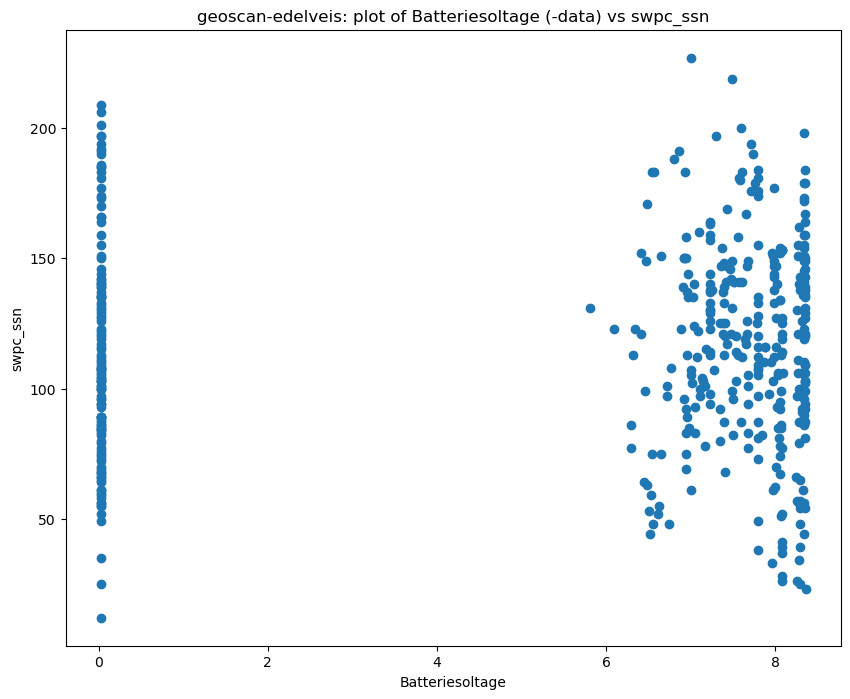

Skipping column=[ArgusNavis]: not enough unique values.
sampling=[448]
Correlation [53385.obc_stamp] vs [swpc_ssn]: classic=[0.04438506952521352], spearman=[0.06106875125644223], kendal_tau=[0.04051348096798995]


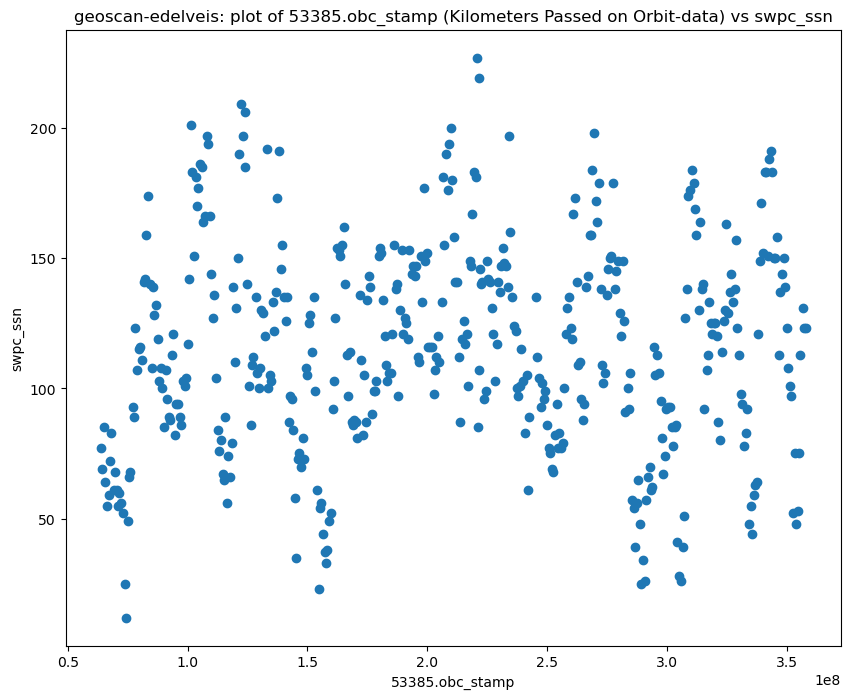

Skipping column=[Comm UHF Modem RSSI]: not enough unique values.
Skipping column=[cumulative_sum]: not enough unique values.


In [456]:
analyze_satellite('geoscan-edelveis')

sampling=[879]
Correlation [batt] vs [swpc_ssn]: classic=[-0.032371961359043015], spearman=[-0.0554378700438293], kendal_tau=[-0.03797842301013247]


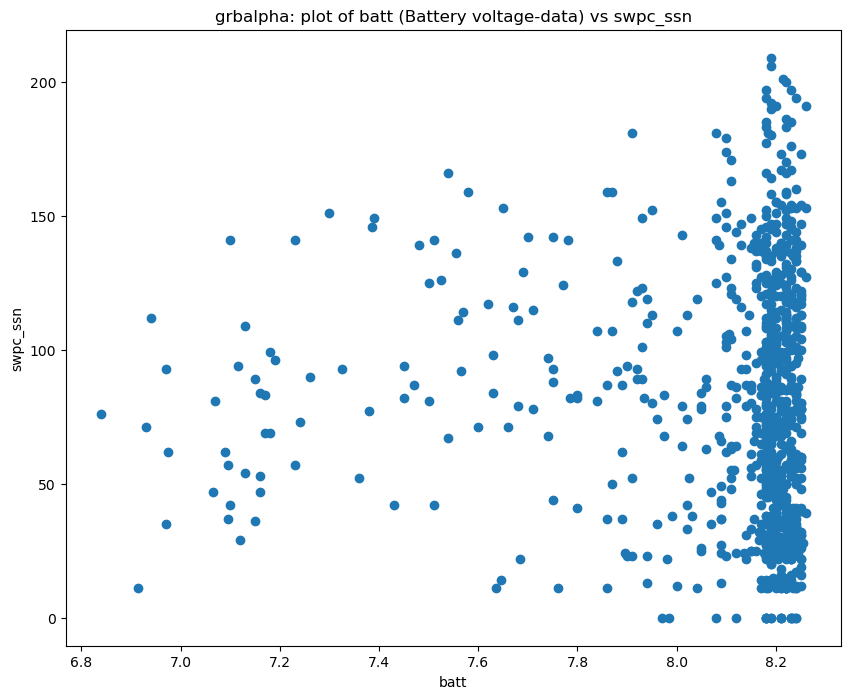

Skipping column=[47959.mcu_10mv]: not enough unique values.
Skipping column=[count]: not enough unique values.


In [457]:
analyze_satellite('grbalpha')

In [458]:
analyze_satellite('ledsat')

Skipping column=[Total current coming from solar panels]: not enough unique values.
Skipping column=[+X solar panel]: not enough unique values.
Skipping column=[X axis MPPT]: not enough unique values.


Skipping column=[0 = discharge, 1 = charge]: not enough unique values.
Skipping column=[Battery current magnitude]: not enough unique values.
Skipping column=[Current feeding BCR1 (+X panel)]: not enough unique values.
sampling=[1449]
Correlation [Elevation (onboard prediction)] vs [swpc_ssn]: classic=[0.02981696417037133], spearman=[-0.32198191160940903], kendal_tau=[-0.2297984743196735]


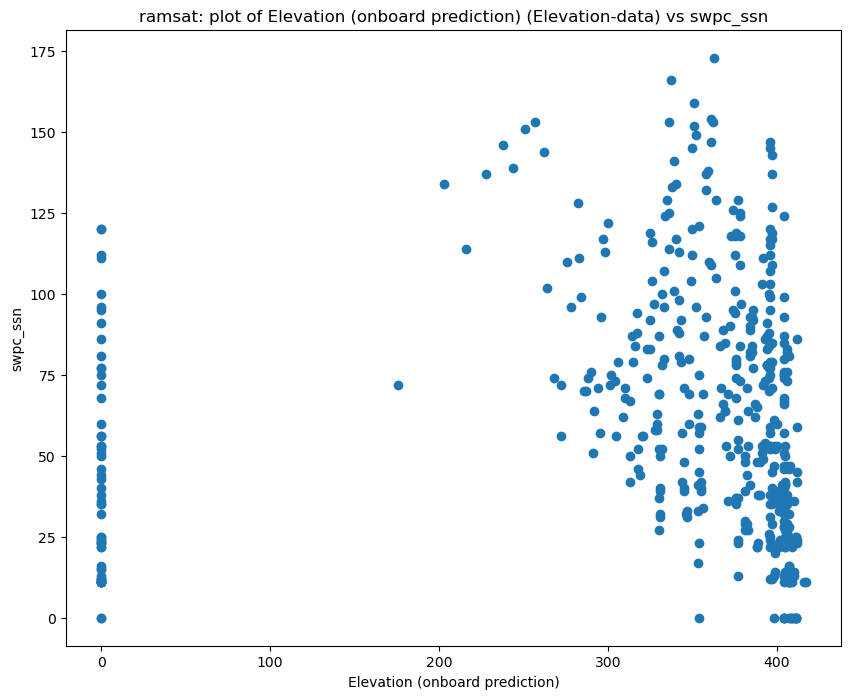

sampling=[1449]
Correlation [Longitude (prediction)] vs [swpc_ssn]: classic=[-0.032273164347221654], spearman=[-0.05961618680142986], kendal_tau=[-0.040373591388467626]


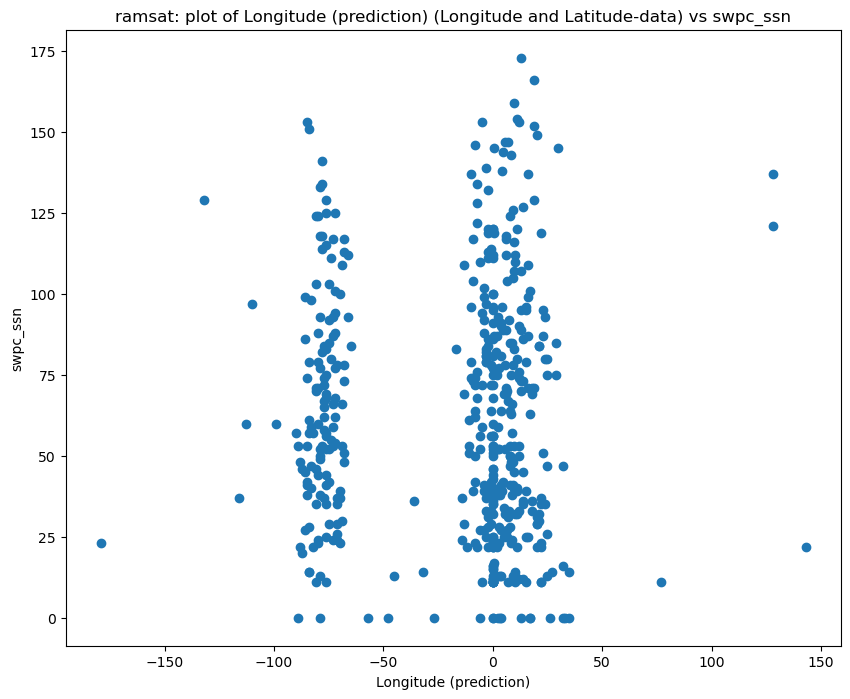

sampling=[1449]
Correlation [X-axis] vs [swpc_ssn]: classic=[0.021373320836430263], spearman=[0.0033361218113460334], kendal_tau=[0.0041191162107821755]


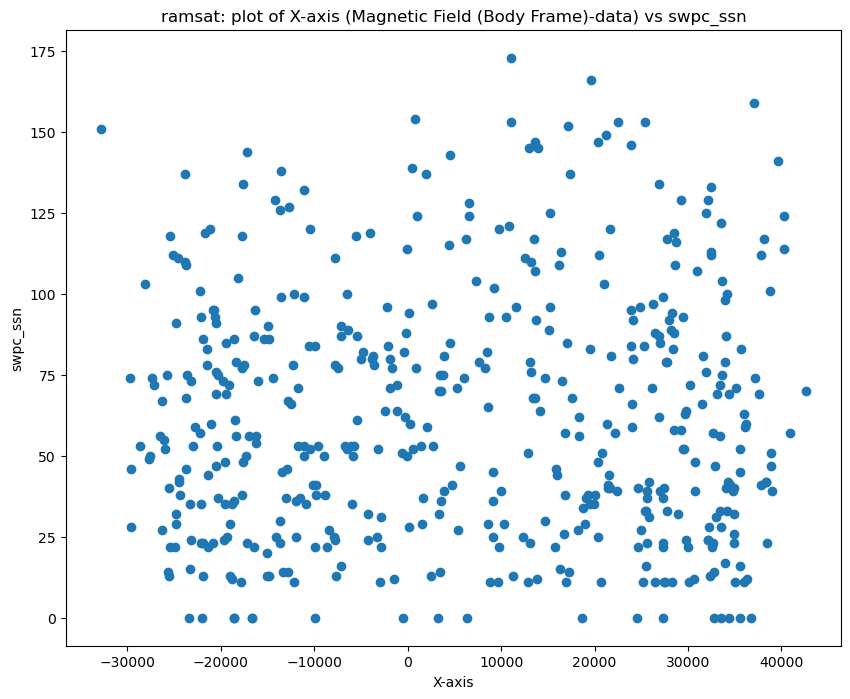

Skipping column=[Sun Sensor -Xa]: not enough unique values.
sampling=[1449]
Correlation [+X panel] vs [swpc_ssn]: classic=[0.10641015166907092], spearman=[0.052314909106261534], kendal_tau=[0.03154320788217926]


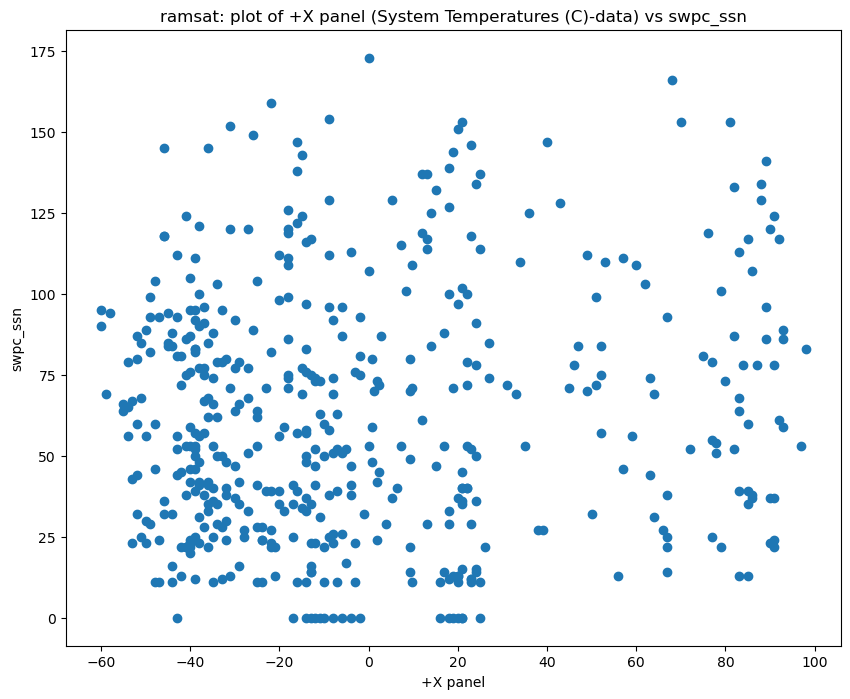

In [459]:
analyze_satellite('ramsat')

Skipping column=[44878.mode]: not enough unique values.
sampling=[1289]
Correlation [44878.mode] vs [swpc_ssn]: classic=[-0.1787243752541007], spearman=[-0.3397847873246419], kendal_tau=[-0.2429687701330934]


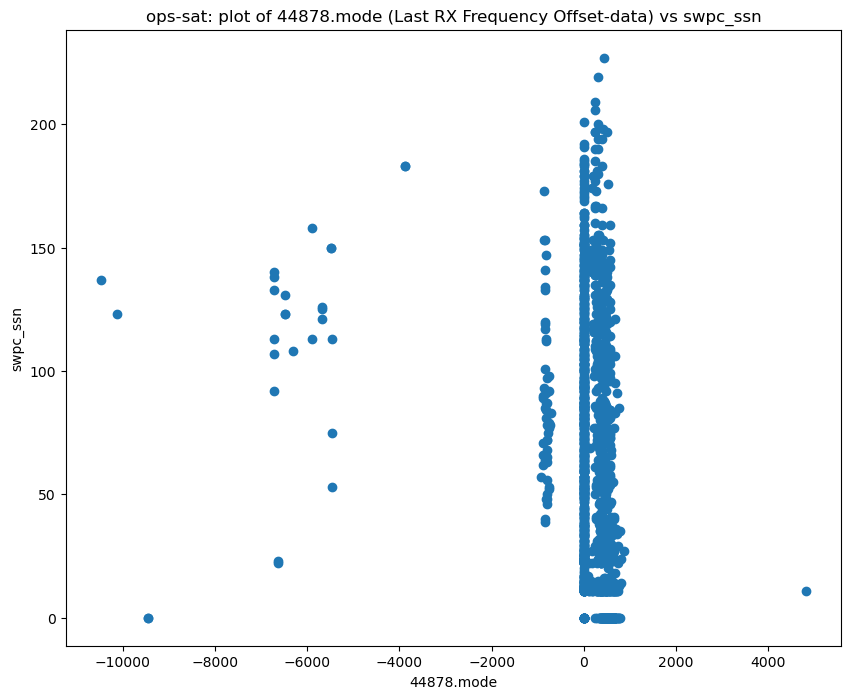

Skipping column=[44878.mode]: not enough unique values.
Skipping column=[Background RSSI Level]: not enough unique values.
sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[-0.261793611402168], spearman=[-0.28165869536918936], kendal_tau=[-0.19665418137960228]


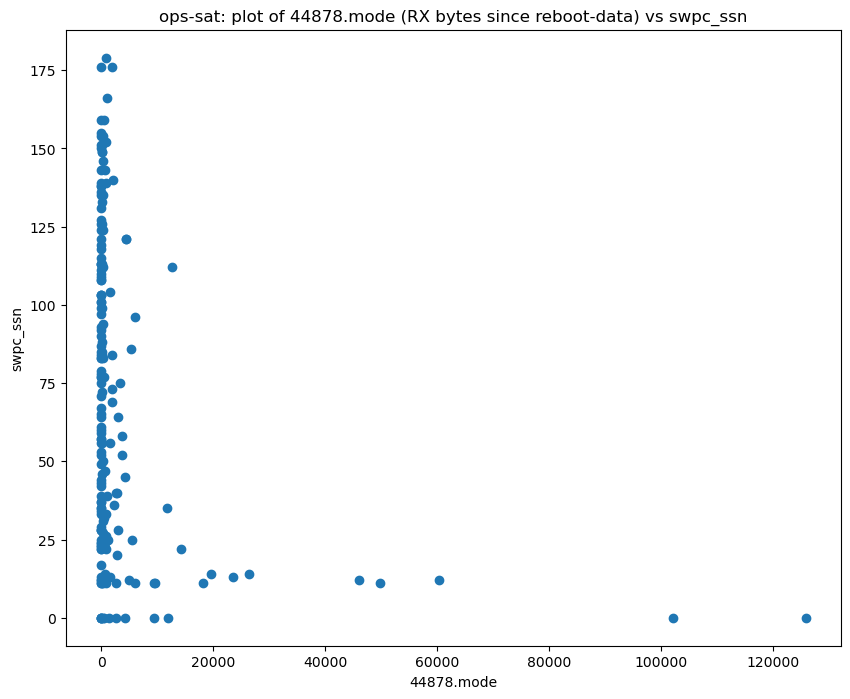

sampling=[1289]
Correlation [44878.mode] vs [swpc_ssn]: classic=[-0.2816047057681802], spearman=[-0.2944798008540808], kendal_tau=[-0.21233242876313882]


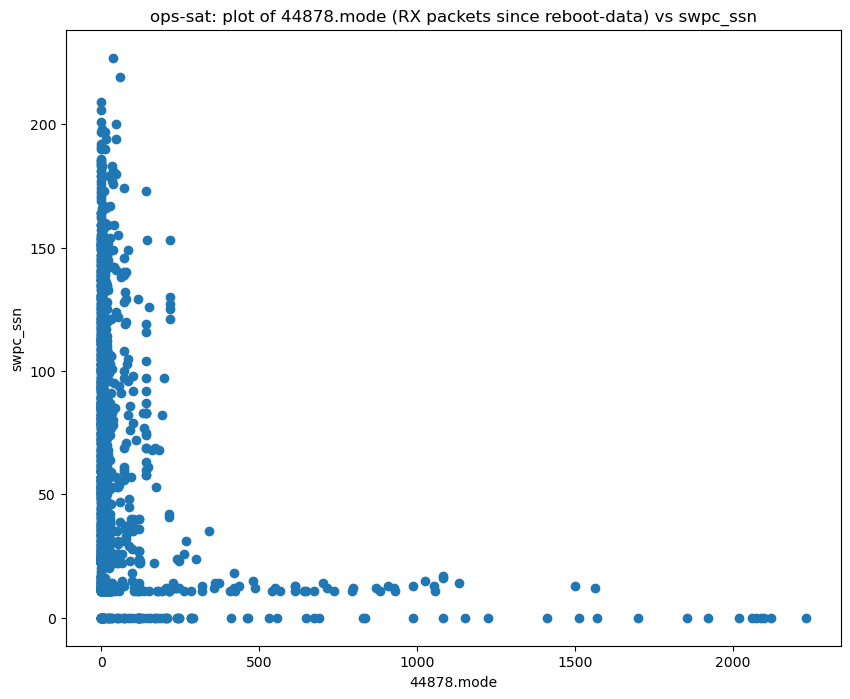

sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[0.5380133871877748], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


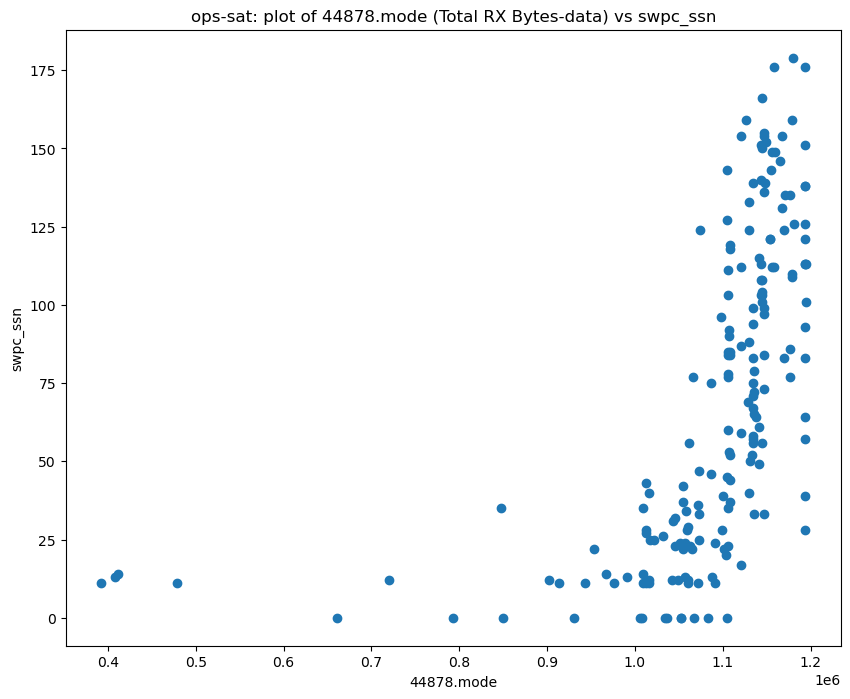

sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[0.5748628313476977], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


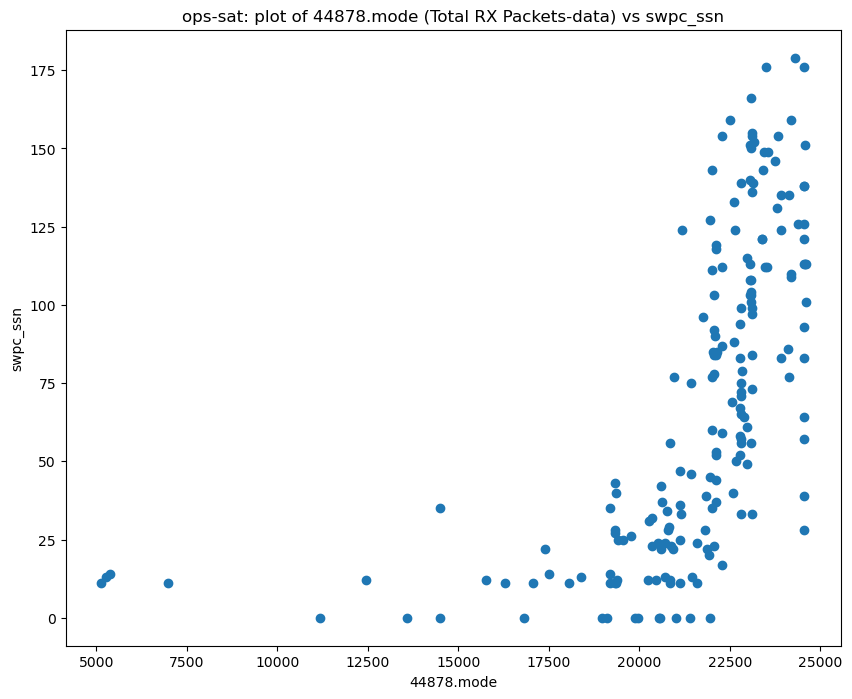

sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[0.5353106560668386], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


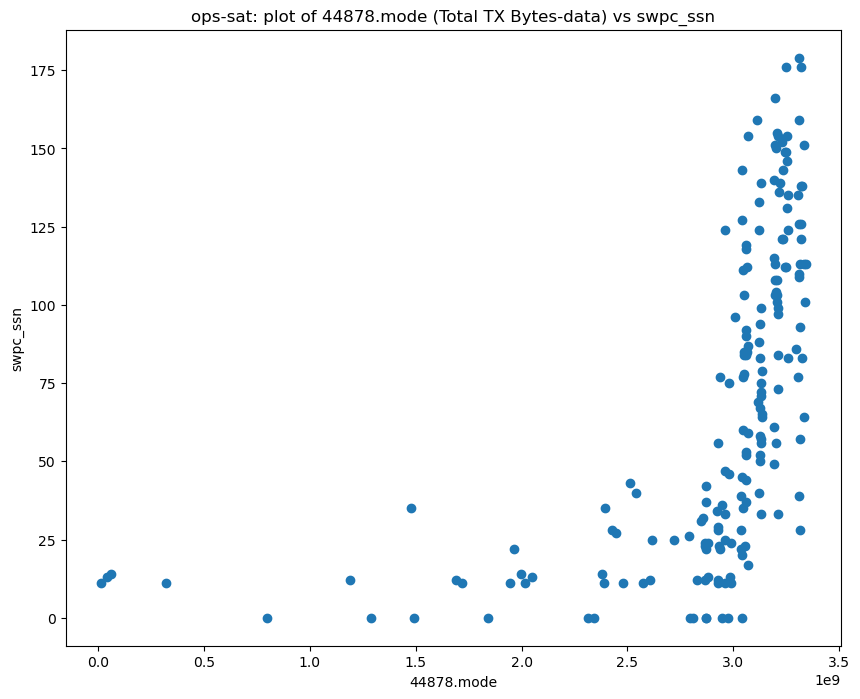

sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[0.5561946696013134], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


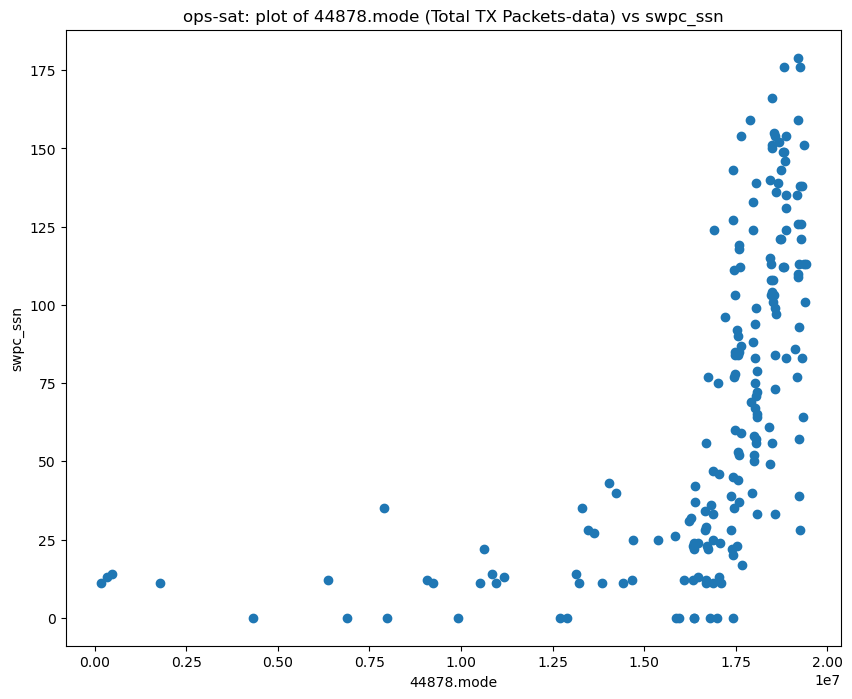

sampling=[188]
Correlation [44878.mode] vs [swpc_ssn]: classic=[-0.2918840914794443], spearman=[-0.27982887225292064], kendal_tau=[-0.18135307800557543]


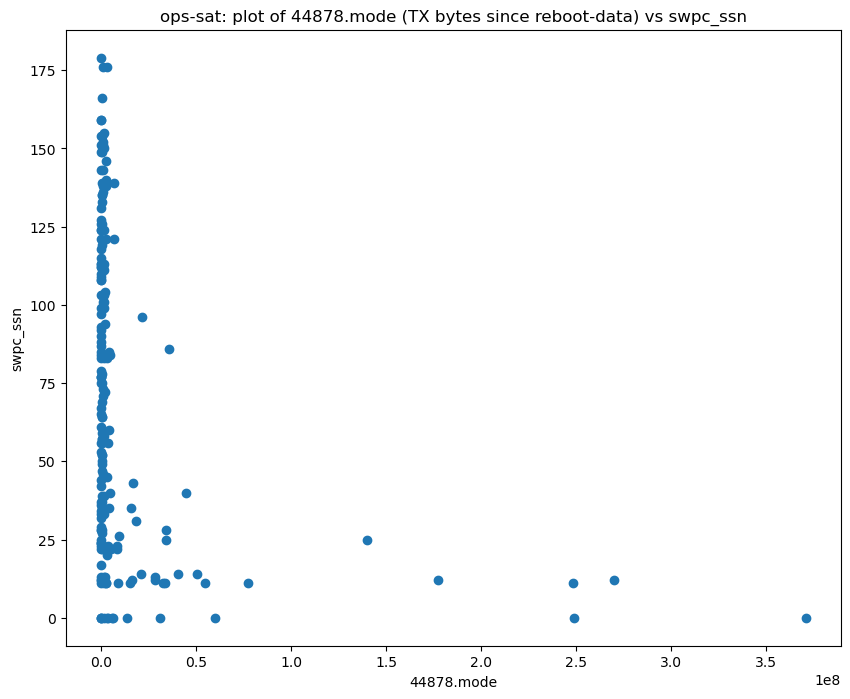

sampling=[1289]
Correlation [44878.mode] vs [swpc_ssn]: classic=[-0.32635194664806416], spearman=[-0.2839994754465362], kendal_tau=[-0.18962512401888412]


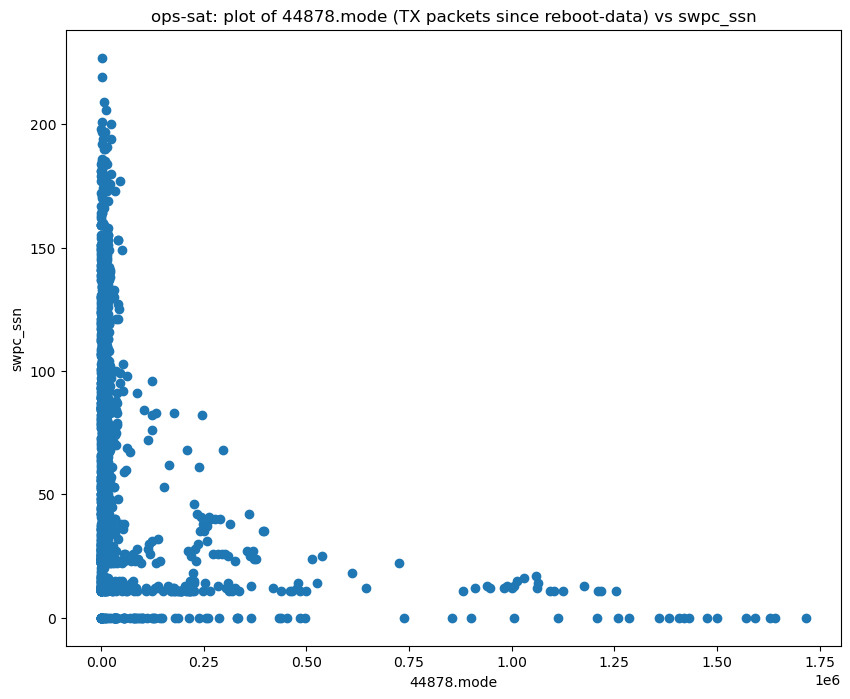

In [460]:
analyze_satellite('ops-sat')

In [461]:
analyze_satellite('veronika')

Skipping column=[58261.psu_reset_cnt]: not enough unique values.
Skipping column=[Battery]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[UHF Act]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping column=[In]: not enough unique values.
Skipping column=[PSU Battery]: not enough unique values.
Skipping column=[X]: not enough unique values.
Skipping column=[OBC MCU]: not enough unique values.
Skipping column=[58261.pid]: not enough unique values.
Skipping column=[58261.mode]: not enough unique values.
Skipping 

/tmp/ipykernel_3149/1563972062.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Skipping column=[Chunk]: not enough unique values.
Skipping column=[ArgusNavis]: not enough unique values.
Skipping column=[last]: not enough unique values.
sampling=[1449]
Correlation [51085.last] vs [swpc_ssn]: classic=[0.4208822649348228], spearman=[0.40885491516883415], kendal_tau=[0.2810224745735555]


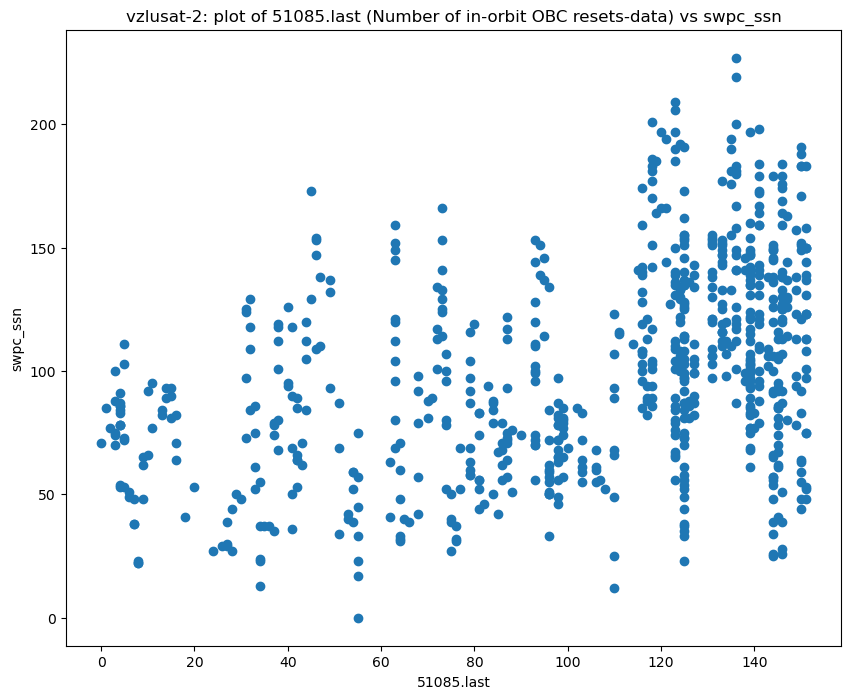

sampling=[1449]
Correlation [51085.cumulative_sum] vs [swpc_ssn]: classic=[0.7194781500359015], spearman=[0.787216346481029], kendal_tau=[0.6050055321470738]


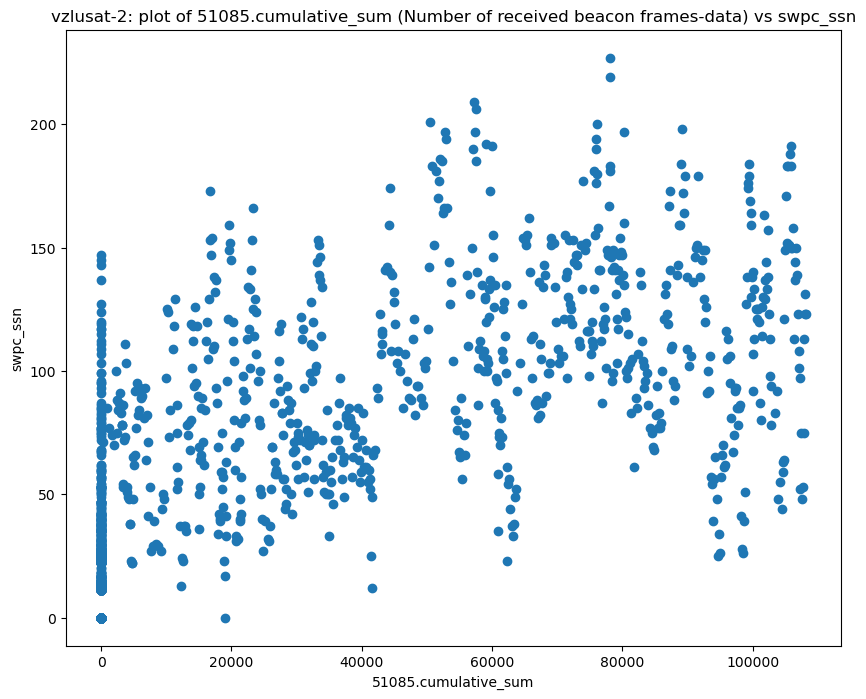

In [462]:
analyze_satellite('vzlusat-2')